<a href="https://colab.research.google.com/github/DanielKorenDataScience/RegressionProject/blob/main/Regression%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laptop Prices prediction using Regression ML model**

# **Source link**

https://www.kaggle.com/muhammetvarl/laptop-price

# **Preliminary**

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import sys
import os
import re

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

In [102]:
data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/RegressionProject/master/laptop_price.csv'
resp = requests.get(data_url)
text = resp.text

with open('laptop_price.csv', 'w') as fh:
    fh.write(text)
  
df = pd.read_csv('laptop_price.csv')
df_origin = pd.read_csv('laptop_price.csv')

In [104]:
df = pd.read_csv('laptop_price.csv', encoding='ISO-8859–1')

# **Knowing the data**

In [ ]:
df.head(5)

In [ ]:
df.nunique()

In [ ]:
df.describe()

In [ ]:
df.T

In [ ]:
df.info(null_counts=True) 

In [ ]:
col = list(df.columns)
for column in col: #.split():
    print(column, ':')
#    df[column] = df[column].str.strip()
    print(df[column].value_counts())
    print()

    """ Product, Screen Resolution, CPU, Weight """

# Conclusions:
1. laptop_ID - Unique, not relevant to the model
2. Company - need to split category to columns
3. Product - ???
4. TypeName - need to split category to columns
5. Inches - need to make rounded
6. ScreenResolution - ???
7. Cpu - I think we should smart seperate to manufacturer and have the model in some other way !?
8. Ram - numeric
9. Memory - storage
10. Gpu - category to column !?
11. OpSys - Important -- category to columns 
12. Weight
13. Price_euros - ***Predict***

# **EDA - Data Exploration**

In [ ]:
df.head(3)

In [ ]:
sns.color_palette("coolwarm", as_cmap=True)
sns.set_theme(style="whitegrid")

In [ ]:
plt.figure(figsize=(20,5))
sns.distplot(df.Price_euros,bins=50, kde=False)

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(data=df, x=df.Company, order = df['Company'].value_counts().index )

In [ ]:
plt.figure(figsize=(20,5))
plot_order = df.groupby('Company')['Price_euros'].sum().sort_values(ascending=False).index.values
sns.barplot(data=df, x=df.Company, y=df.Price_euros, order=plot_order )

In [ ]:
df.sort_values('Price_euros', inplace=True, ascending=False)
sns.barplot(data=df, x=df['Ram'], y=df['Price_euros'])

In [ ]:
sns.countplot(data=df, x='Ram', order = df['Ram'].value_counts().index)

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='OpSys') #, y='Price_euros')

In [ ]:
plt.figure(figsize=(9,5))
plot_order = df.groupby('TypeName')['Price_euros'].count().sort_values(ascending=False).index.values
sns.countplot(data=df, x='TypeName', order=plot_order)

In [ ]:
sns.jointplot(x='Inches',y='Price_euros', kind='scatter', data=df)

In [ ]:
sns.jointplot(x='TypeName', y='Price_euros', kind='scatter', data=df, height=11)

# **Data Cleaning**

In [ ]:
df.Price_euros.sort_values().tail(10)

In [ ]:
#removing noisy values - prices over 3000
df = df[df['Price_euros'] <= 3000]

# **Data Manipulation**

In [ ]:
df.nunique()

In [ ]:
df.head(2)

In [ ]:
df_Company = pd.get_dummies(df.Company, prefix='co_')
df_Product = pd.get_dummies(df.Product, prefix='prd_')
df_TypName = pd.get_dummies(df.TypeName, prefix='tpn_')
df_os = pd.get_dummies(df.OpSys, prefix='os_')

In [ ]:
# Round inch information 
df.Inches = df.Inches.round()

# Ram to number
df.Ram = df.Ram.str.replace('GB','').astype(int)

# Weight to number
df.Weight = df.Weight.str.replace('kg','').astype(float)

# Memory to number
# memory split
df['Memory_SSD']= np.where(df.Memory.str.find("SSD")==-1,0,1)
df['Memory_Flash_Storage']= np.where(df.Memory.str.find("Flash Storage")==-1,0,1)
df['Memory_HDD']= np.where(df.Memory.str.find("HDD")==-1,0,1)
df['Memory_Hybrid']= np.where(df.Memory.str.find("Hybrid")==-1,0,1)
df['Storage_amt'] = df.Memory.str.split().str[0]
storage_map = {'1.0TB':'1000', '1TB':'1000', '2TB':'2000', '508':'500'}
df.Storage_amt.replace(storage_map , inplace=True)
df.Storage_amt = df.Storage_amt.str.replace('GB','').astype(int)

# Split Cpu information 
df['Cpu_brand'] = df.Cpu.str.split().str[0]
df['Cpu_speed'] = df.Cpu.str.split().str[-1]
df.Cpu_speed = df.Cpu_speed.str.split('GHz').str[0].astype(float)
#df['Cpu_model'] = 
df_Cpu_brand = pd.get_dummies(df.Cpu_brand, prefix='Cpu_')

# CPU
df['Cpu_HighSeries']=np.where((df.Cpu.str.split(" ",1).str[0]=="AMD") | (df.Cpu.str.split(" ",1).str[0]=="Samsung"),df.Cpu.str.split(" ",1).str[1].str.split(" ",1).str[0],
          np.where((df.Cpu.str.split(" ",1).str[0]=="Intel") & (df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0].isin(['Xeon','Atom'])),df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0],
          np.where(df.Cpu.str.split(" ",1).str[0]=="Intel",df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[0]+df.Cpu.str.split(" ",1).str[1].str.split(" ",2).str[1],     
          "missing")))
df_Cpu_HighSeries = pd.get_dummies(df.Cpu_HighSeries, prefix='CpuH_')

test1=df.Cpu.str.split().str[-2].str.split("-").str[-1]
test2=test1.apply(lambda x:re.findall(r'\d+|$',x)[0])
test2.replace([""],["0"],inplace=True)
test2=test2.astype(int)
df['Cpu_LowSeries']=np.where(test2<10,0,test2)

# Split Gpu information
df['Gpu_brand'] = df.Gpu.str.split().str[0]
df_Gpu_brand = pd.get_dummies(df.Gpu_brand, prefix='Gpu_')
df['Gpu_SubType']=np.where(df.Gpu.str.split(" ",2).str[1].isin(['Graphics','R17M-M1-70','Mali','R4']),'missing',df.Gpu.str.split(" ",2).str[1])
df_Gpu_SubType = pd.get_dummies(df.Gpu_SubType, prefix='GpuST_')

# Handle ScreenResolution information
df['Scr_to'] = df.ScreenResolution.str.split('x').str[-1]
df['Scr_from'] = df.ScreenResolution.str.split('x').str[0]
df['Scr_from'] = df.Scr_from.str.split().str[-1]
df['Scr_Touchscreen']=np.where(df.ScreenResolution.str.find("Touchscreen")>-1,1,0)
df['Scr_HD']=np.where(df.ScreenResolution.str.find("Full HD")>-1,'Full_HD',
                    np.where(df.ScreenResolution.str.find("Quad HD")>-1,'Quad_HD',
                    np.where(df.ScreenResolution.str.find("Ultra HD")>-1,'Ultra_HD',
                             'missing')))
df_Scr_HD = pd.get_dummies(df.Scr_HD, prefix='ScrHD_')

In [ ]:
# Combining the Data
df_model = pd.merge(df[['Inches', 'Ram', 'Weight', 'Price_euros', 'Storage_amt', 'Cpu_speed', 'Scr_from', 'Scr_to','Memory_SSD','Memory_Flash_Storage','Memory_HDD','Memory_Hybrid','Cpu_LowSeries','Scr_Touchscreen']], df_Company, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Product, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_TypName, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_os, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Cpu_brand, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Gpu_brand, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Cpu_HighSeries, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Gpu_SubType, left_index=True, right_index=True)
df_model = pd.merge(df_model, df_Scr_HD, left_index=True, right_index=True)
#df.drop(['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys'], axis=1, inplace=True)

df_model.head(2)

In [ ]:
df_model.shape

# **Decision Tree Model**

In [120]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

In [121]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [122]:
#model = RandomForestClassifier()
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5).fit(X_train, y_train)

In [123]:
importances = model.feature_importances_

In [124]:
y_train_pred = model.predict(X_train)

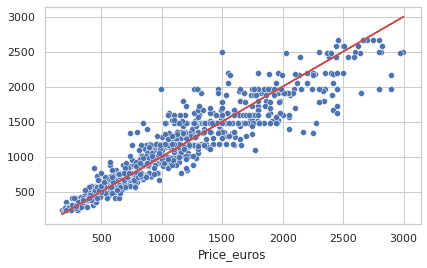

In [125]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [126]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

208.02348320080554

In [155]:
y_test_pred = model.predict(X_test)

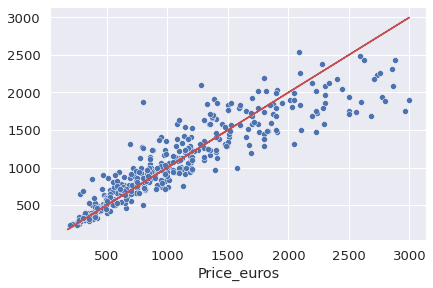

In [156]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [129]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

338.787237405432

Text(0.5, 11.552000000000007, 'prediction error')

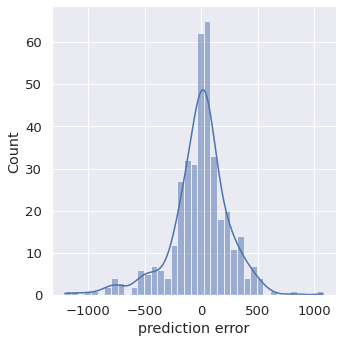

In [157]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [158]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

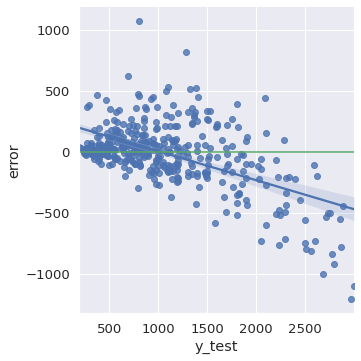

In [159]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

Text(0.5, 0, 'min samples per leaf')

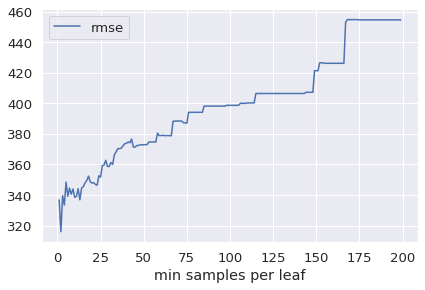

In [160]:
rmse_list = []

min_samples_leaf_range = range(1, 200)

result = pd.DataFrame(index=min_samples_leaf_range, columns =['rmse'])

for i in min_samples_leaf_range:
    model = DecisionTreeRegressor(min_samples_leaf=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


result.plot()
plt.xlabel('min samples per leaf')

Text(0.5, 0, 'max depth')

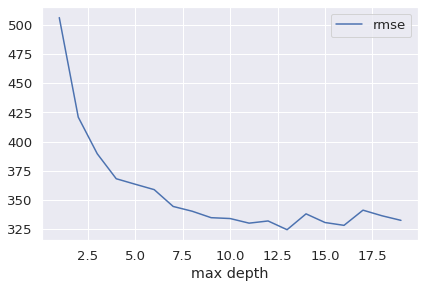

In [161]:
rmse_list = []

max_depth = range(1, 20)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in max_depth:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse




result.plot()
plt.xlabel('max depth')

Text(0.5, 0, 'min_samples_split')

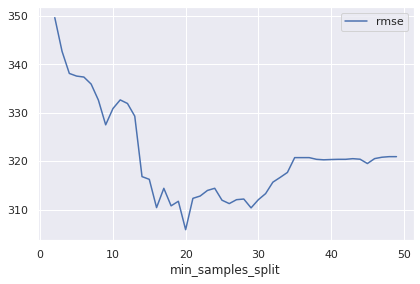

In [165]:
rmse_list = []

min_samples_split = range(2, 50)

result = pd.DataFrame(index=max_depth, columns =['rmse'])

for i in min_samples_split:
    model = DecisionTreeRegressor(min_samples_split=i)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    rmse = np.sqrt(mse(y_test, y_fit))
    result.loc[i, 'rmse'] = rmse


#display(result.head(30))
result.plot()
plt.xlabel('min_samples_split')

In [130]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

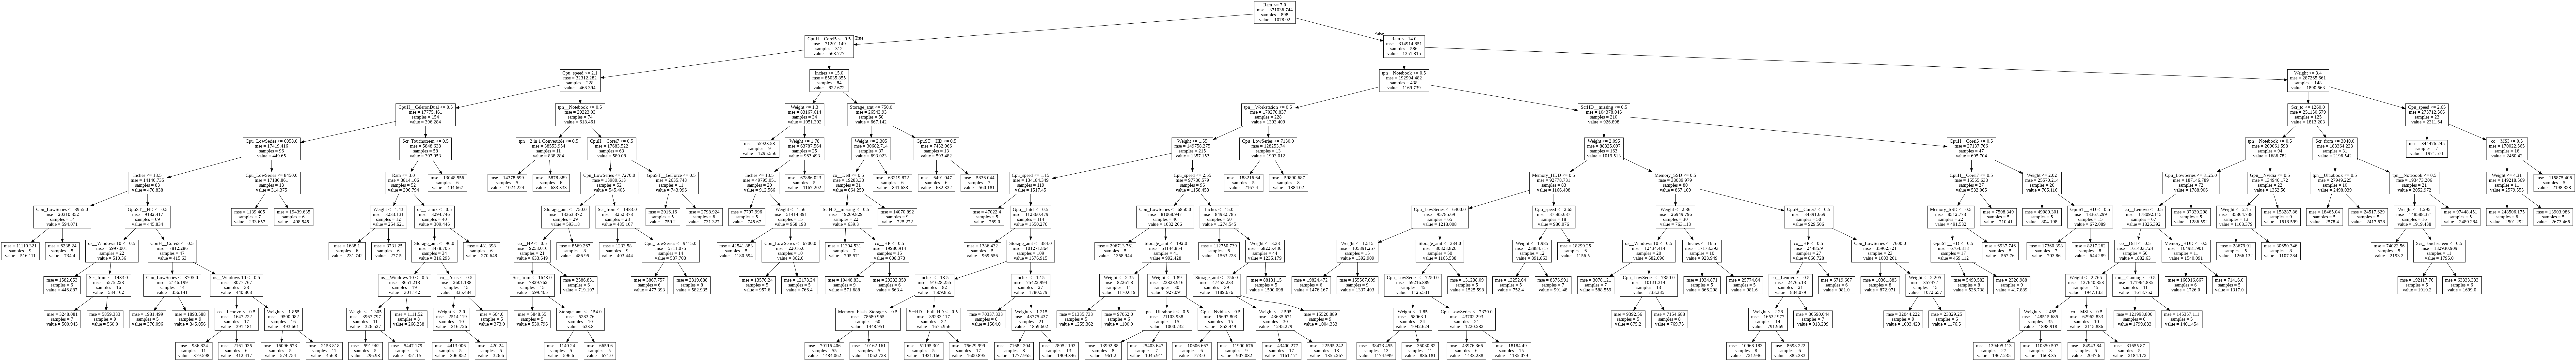

In [131]:
visualize_tree(model, md=100)

In [132]:
importances[::-1].sort() 

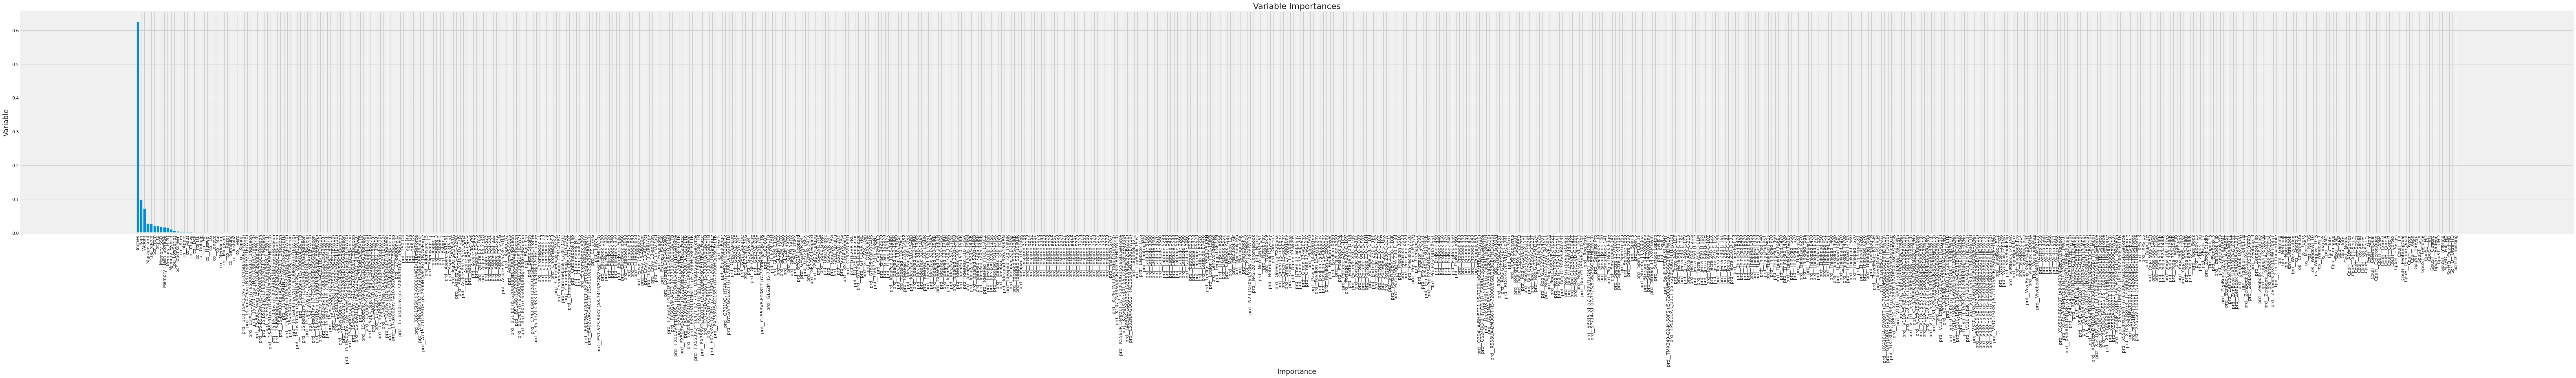

In [133]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

In [166]:
#model = RandomForestClassifier()
model = DecisionTreeRegressor(max_depth=13, min_samples_leaf=3,min_samples_split=20).fit(X_train, y_train)

In [167]:
y_train_pred = model.predict(X_train)

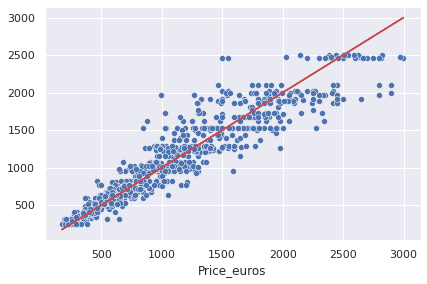

In [168]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [169]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

207.40190875640116

In [170]:
y_test_pred = model.predict(X_test)

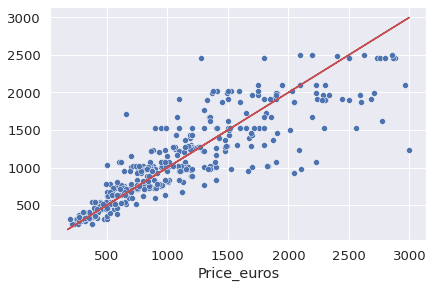

In [171]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [172]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

316.5783388121354

Text(0.5, 11.552000000000007, 'prediction error')

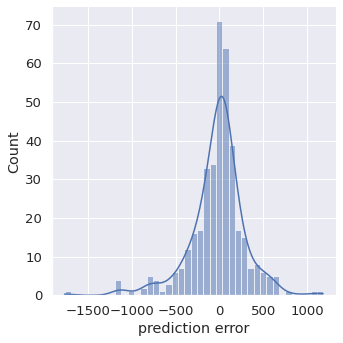

In [173]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [174]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

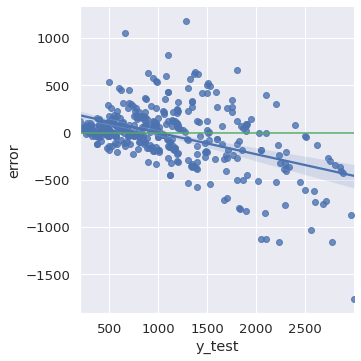

In [175]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

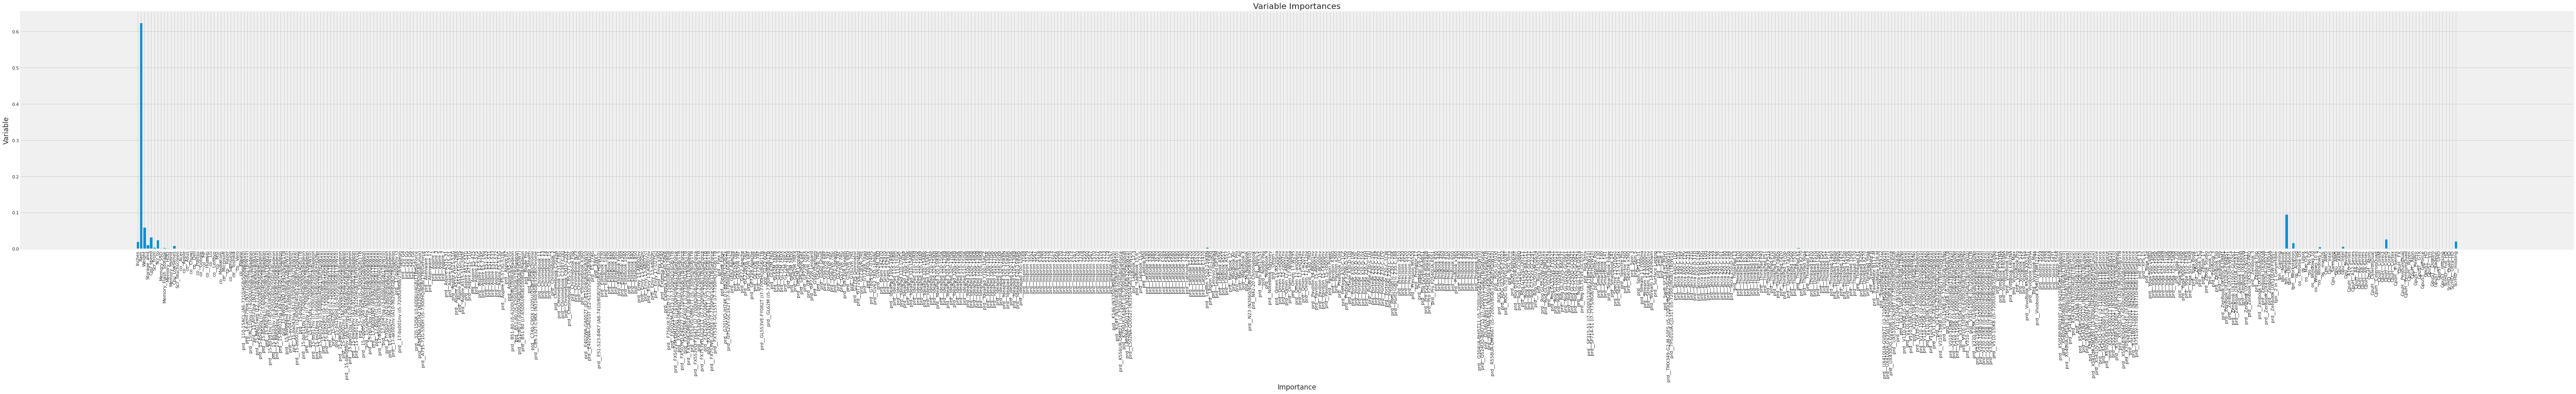

In [178]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

# Random Forest Model

In [108]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

In [109]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [110]:
# Baseline
# The baseline predictions are the historical averages
#baseline_preds = X_test[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
#baseline_errors = abs(baseline_preds - y_test)
#print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [111]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [134]:
y_train_pred = rf.predict(X_train)

In [112]:
# Use the forest's predict method on the test data
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 184.83 degrees.


In [113]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.46 %.


In [114]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

In [115]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

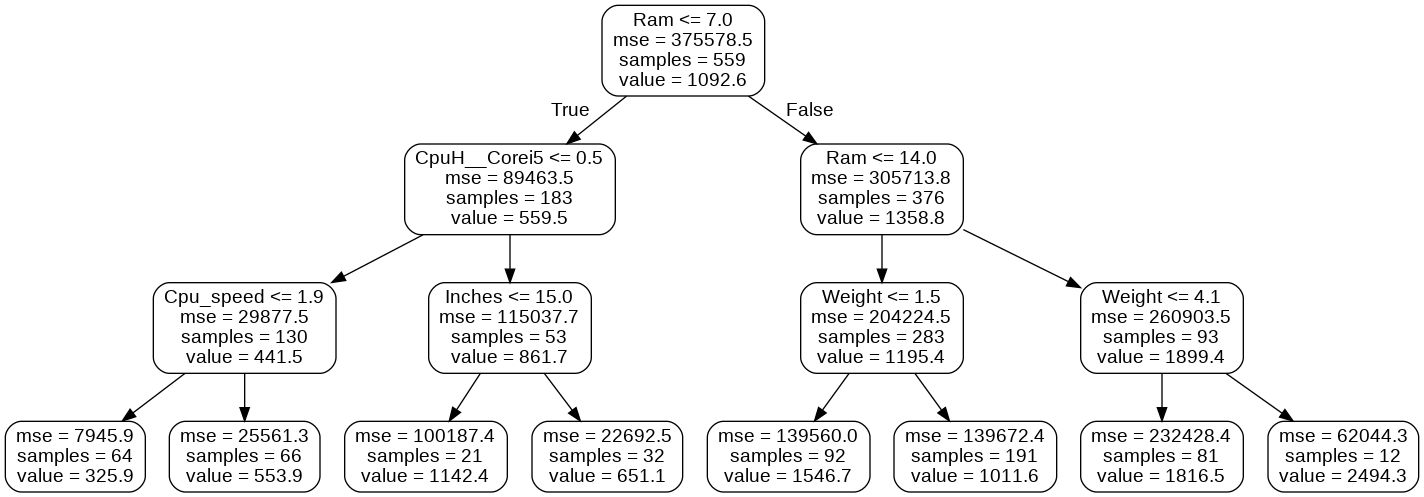

In [116]:
### display small_tree.png
Image(filename='small_tree.png') 

In [117]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [135]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

91.29772957220551

In [119]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

289.89744018258364

In [136]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

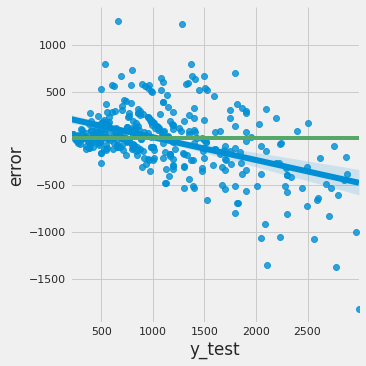

In [137]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [139]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,200,500,1000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth" :[4,8,10,12,16,20],
            "min_samples_split" : [2,4,8,10,12],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [140]:
Grid_Search_CV_RFR(X_train,y_train)

KeyboardInterrupt: ignored

# if required to re-run the model

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ram'), feature_list.index('Weight'), feature_list.index('tpn__Notebook')]
#train_important = X_train[:, important_indices]
#test_important = X_test[:, important_indices]
# Train the random forest
#rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
#predictions = rf_most_important.predict(test_important)
#errors = abs(predictions - test_labels)
# Display the performance metrics
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
#mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
importances.sort(reverse=True)

In [ ]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

# Linear Regression Model

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
#print(__doc__)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [ ]:
print(regr.intercept_)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_train_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

In [ ]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,  c='red')
plt.title('Price in EUR - Actual vs Predicted', size=20)
plt.show()

In [ ]:
sns.displot(y_pred - y_test, kde=True)
plt.xlabel('prediction error (EUR)')

# K Nearest Neighbors Model

In [141]:
X = df_model.drop('Price_euros', axis=1)
y = df_model['Price_euros']
feature_list = list(X.columns)

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [142]:
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

In [ ]:
y_train_pred = model.predict(X_train)

In [143]:
pd.Series(y_train_pred).value_counts()

763.514540     3
895.127460     3
719.038030     3
1026.474666    2
1553.465840    2
              ..
1676.062787    1
1453.515180    1
1502.611240    1
1339.947140    1
1942.106866    1
Length: 866, dtype: int64

In [144]:
y_test_pred = model.predict(X_test)

In [145]:
pd.Series(y_test_pred).value_counts()

457.335000     4
527.480000     4
805.943333     3
999.165000     3
1582.333333    3
              ..
919.163333     1
844.266667     1
942.473333     1
789.333333     1
910.500000     1
Length: 305, dtype: int64

In [146]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

91.29772957220551

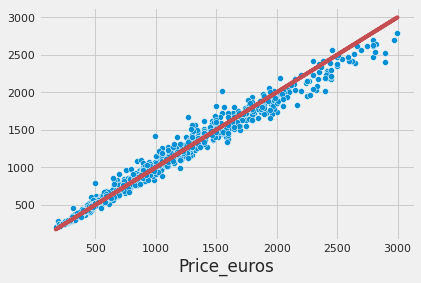

In [148]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
sns.set(font_scale=1.2)

In [147]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

269.108350534548

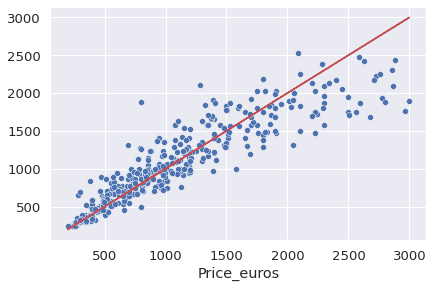

In [149]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
sns.set(font_scale=1.2)

Text(0.5, 11.552000000000007, 'prediction error')

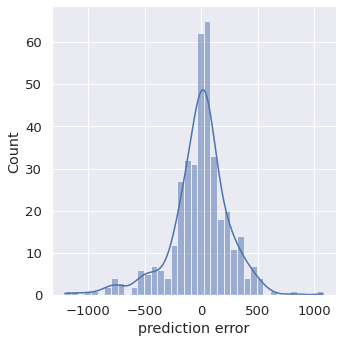

In [150]:
sns.displot(y_test_pred - y_test, kde=True)
plt.xlabel('prediction error')

In [151]:
testDf=pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

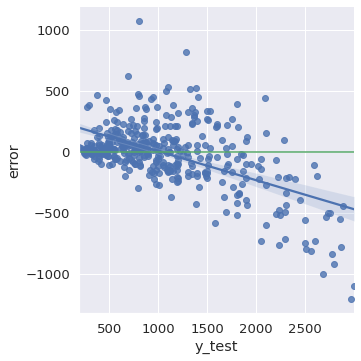

In [152]:
sns.lmplot(
    x='y_test', 
    y='error',
    data=testDf.assign(error = testDf['y_test_pred'] - testDf['y_test'])
)
#plt.ylim(np.array(plt.xlim())*1.2)
plt.axhline(0, c='g')

In [154]:
#features=X_train.columns
#importances = model.feature_importances_
#indices = np.argsort(importances)
#sns.set(font_scale=1)
#plt.figure(figsize=(10,10))
#plt.figure(1)
#plt.title('Feature Importances Price')
#plt.barh(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), features[indices])
#plt.xlabel('Relative Importance')

# **Building Categorical Dataset**

In [ ]:
df_origin.head(2)

In [ ]:
def GroupPrice(GroupValue,dfOrg):
  df_origin=dfOrg.groupby(GroupValue).agg({'Price_euros':[('avgPrice','mean'),('stdPrice',np.std)],'laptop_ID':[('countLaptop','count')]}).reset_index()
  df_origin.columns=df_origin.columns.droplevel(0)
  df_origin.columns.values[0]=GroupValue
  df_origin.sort_values('countLaptop',ascending=False,inplace=True)
  valueByPrice=df_origin.sort_values('avgPrice',ascending=False)[GroupValue].tolist()
  print(valueByPrice)
  dict_map = dict(zip(valueByPrice, range(len(valueByPrice))))
  dfOrg.loc[:, GroupValue+'Num'] = dfOrg[GroupValue].map(dict_map)
  return dfOrg

In [ ]:
df_origin=GroupPrice('Company',df_origin)
display(df_origin[['Company','CompanyNum']].head(10))

In [ ]:
types=GroupPrice('TypeName',df_origin)
display(types[['TypeName','TypeNameNum']].head(10))

In [ ]:
df_origin=GroupPrice('Scr_HD',df)
display(df_origin[['Scr_HD','Scr_HDNum']].head(10))

In [ ]:
df_origin=GroupPrice('Cpu_HighSeries',df_origin)
display(df_origin[['Cpu_HighSeries','Cpu_HighSeriesNum']].head(10))

In [ ]:
df_origin=GroupPrice('Gpu_brand',df_origin)
display(df_origin[['Gpu_brand','Gpu_brandNum']].head(10))

In [ ]:
df_origin=GroupPrice('Gpu_SubType',df_origin)
display(df_origin[['Gpu_SubType','Gpu_SubTypeNum']].head(10))

In [ ]:
df_origin=GroupPrice('OpSys',df_origin)
display(df_origin[['OpSys','OpSysNum']].head(10))

In [ ]:
df_origin.head(2)

In [ ]:
df_model_cat=df_origin[['Inches', 'Ram', 'Weight',  'Storage_amt', 'Cpu_speed', 'Scr_from', 'Scr_to','Memory_SSD','Memory_Flash_Storage','Memory_HDD','Memory_Hybrid','Cpu_LowSeries',
             'Scr_Touchscreen','CompanyNum','TypeNameNum','Scr_HDNum','Cpu_HighSeriesNum','Gpu_brandNum','Gpu_SubTypeNum','OpSysNum','Price_euros']].copy()

In [ ]:
df_model_cat.head(2)

In [ ]:
df_model_cat.shape

In [ ]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(40,20))        
# Imbalanced DataFrame Correlation
corr = df_model_cat.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':20},annot=True, ax=ax)
sns.set(font_scale=2)
ax.set_title("Correlation Matrix", fontsize=25)
plt.show()

# **Decision Tree Model On Categorical Dataset**

In [ ]:
X = df_model_cat.drop('Price_euros', axis=1)
y = df_model_cat['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
#model = RandomForestClassifier()
model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5).fit(X_train, y_train)

In [ ]:
importances = model.feature_importances_

In [ ]:
y_train_pred = model.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

In [ ]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

In [ ]:
visualize_tree(model, md=100)

In [ ]:
importances[::-1].sort() 

In [ ]:
plt.figure(figsize=(100,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

# **Random Forest Model On Categorical Dataset**

In [ ]:
X = df_model_cat.drop('Price_euros', axis=1)
y = df_model_cat['Price_euros']
feature_list = list(X.columns)

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
# Baseline
# The baseline predictions are the historical averages
#baseline_preds = X_test[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
#baseline_errors = abs(baseline_preds - y_test)
#print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
y_test_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_test_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
### display small_tree.png
Image(filename='small_tree.png') 

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# Linear Regression Model On Categorical Dataset




In [ ]:
X = df_model_cat.drop('Price_euros', axis=1)
y = df_model_cat['Price_euros']
feature_list = list(X.columns)

X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)

In [ ]:
#print(__doc__)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [ ]:
print(regr.intercept_)

In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

In [ ]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,  c='red')
plt.title('Price in EUR - Actual vs Predicted', size=20)
plt.show()

In [ ]:
sns.displot(y_pred - y_test, kde=True)
plt.xlabel('prediction error (EUR)')